# Tutorial - Observables

In the previous tutorial, we simulated a population of identical individuals: The difference in their behavior was solely due to different random shocks to the reward associated with a choice. In more realistic models, one or more observed characteristic (or **observables**) can be distributed unevenly within a population. For instance, agents can differ with respect to demographic or other characteristics, such as age, gender,income, where they live or whether they went to college. 
These observables need to be sampled before simulating the model. 

In this tutorial we will learn how to enrich our baseline Robinson Crusoe economy with observables: The simulated Robinsons will differ with respect to the fishing grounds and weather conditions they experience on the island.

In [1]:
%matplotlib inline

import pandas as pd
import respy as rp
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# Plot style
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

## The model: a simple Robinson Crusoe economy, revisited

We revisit the basic Robinson Crusoe economy described in the [tutorial](../tutorials/tutorial_params_options_simulate.html) on `params`, `options`, and simulation. We add one observable characteristic to the baseline model, `"Fishing_Grounds"`: Now Robinson can end up, with a certain probability, on the side of the island which has `"poor"` or `"rich"` fishing grounds. Experiencing rich fishing grounds affects the **non-pecuniary reward** for fishing: 

$$\begin{align}
N^f = \alpha^f + \delta^f \unicode{x1D7D9}_{\{FG = "rich"\}} \\
\end{align}$$

The indicator function $\unicode{x1D7D9}_{\{condition\}}$ takes value 1 when the condition is true and value 0 otherwise: Therefore, if Robinson finds himself in rich fishing grounds, his total non-pecuniary rewards from fishing will be equal to $\alpha^f + \delta^f$. 

## Specification: ``params`` and ``options``

To introduce observables we need to modify both `params` and `options`. The observable needs to be identified by the keyword `observable_*_*`, while we can use labels to identify its levels (in this case, `"rich"` and `"poor"`). Everything after the last underscore is considered to be the level's label.

First, we load the specifications of the basic model:

In [2]:
params, options = rp.get_example_model("robinson_crusoe_basic", with_data=False)

Then, we add three additional rows to `params`, to specificy:

- The probability with which Robinson will find himself in rich and in poor fishing grounds;
- The value of $\delta^f$, which here is set to be positive and constant. 

`respy` allows for complex probability distributions of observables, which may for instance depend on other covariates.
However, throughout this tutorial, we will assume that the observables' probability distributions do not depend on any other information, and we will add them to the model via **probability mass function**: Each Robinson is randomly assigned to a certain side of the island, according to the float specified under `value` in the name-level `probability`. 

In [3]:
params.loc[("observable_fishing_grounds_rich", "probability"), "value"] = 0.5
params.loc[("observable_fishing_grounds_poor", "probability"), "value"] = 0.5
params.loc[("nonpec_fishing", "rich_fishing_grounds"), "value"] = 0.3

In [4]:
params

value
category                        name                       
delta                           delta                  0.95
wage_fishing                    exp_fishing            0.30
nonpec_fishing                  constant              -0.20
nonpec_hammock                  constant               2.00
shocks_sdcorr                   sd_fishing             0.50
                                sd_hammock             0.50
                                corr_hammock_fishing   0.00
observable_fishing_grounds_rich probability            0.50
observable_fishing_grounds_poor probability            0.50
nonpec_fishing                  rich_fishing_grounds   0.30

We also need to overwrite the covariates section of `options` to include which level of the observable is associated with a higher nonpecuniary reward for fishing:

In [5]:
options["covariates"] = {
    "constant": "1",
    "rich_fishing_grounds": "fishing_grounds == 'rich'",
}

## Simulation

We will now sample and simulate 1000 Robinsons, which will differ with respect to their `"Fishing_Grounds"` value. We will then let the decision rule from the solution of the model guide them for 5 periods, during which their `"Fishing_Grounds"` value assigned at the start of the simulation cannot change. 

In [6]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

Note that the new characteristic is displayed in a column of the resulting dataset:

In [7]:
df.head(20)

Experience_Fishing Fishing_Grounds  Shock_Reward_Fishing  \
Identifier Period                                                             
0          0                        0            rich              1.431303   
           1                        1            rich              0.383519   
           2                        1            rich              0.950278   
           3                        2            rich              0.582585   
           4                        3            rich              1.680125   
1          0                        0            rich              1.419559   
           1                        1            rich              2.408754   
           2                        2            rich              0.655700   
           3                        3            rich              0.464923   
           4                        4            rich              2.757647   
2          0                        0            rich              1.116904   
           1                        1            rich              0.896039   
           2                        2            rich              0.461766   
           3                        2            rich              1.350840   
           4                        3            rich              0.776213   
3          0                        0            poor              1.106631   
           1                        1            poor              0.383690   
           2                        2            poor              1.798205   
           3                        3            poor              1.734778   
           4                        4            poor              0.861123   

                   Meas_Error_Wage_Fishing  Shock_Reward_Hammock  \
Identifier Period                                                  
0          0                             1              0.515252   
           1                             1              0.529793   
           2                             1             -0.189833   
           3                             1             -0.585088   
           4                             1             -0.108781   
1          0                             1              1.121115   
           1                             1              0.133023   
           2                             1              0.650588   
           3                             1             -0.308845   
           4                             1             -0.133189   
2          0                             1             -1.094805   
           1                             1              0.452955   
           2                             1              0.762777   
           3                             1              0.571080   
           4                             1              0.410387   
3          0                             1             -0.060911   
           1                             1             -0.377365   
           2                             1             -0.600881   
           3                             1             -0.466337   
           4                             1             -0.354589   

                   Meas_Error_Wage_Hammock   Choice      Wage  Discount_Rate  \
Identifier Period                                                              
0          0                             1  fishing  1.431303           0.95   
           1                             1  hammock       NaN           0.95   
           2                             1  fishing  1.282740           0.95   
           3                             1  fishing  1.061539           0.95   
           4                             1  fishing  4.132441           0.95   
1          0                             1  fishing  1.419559           0.95   
           1                             1  fishing  3.251478           0.95   
           2                             1  fishing  1.194763  

Robinson's behavior is affected by the observable we introduced: The figure below shows that rich fishing grounds lead to higher engagement in fishing.

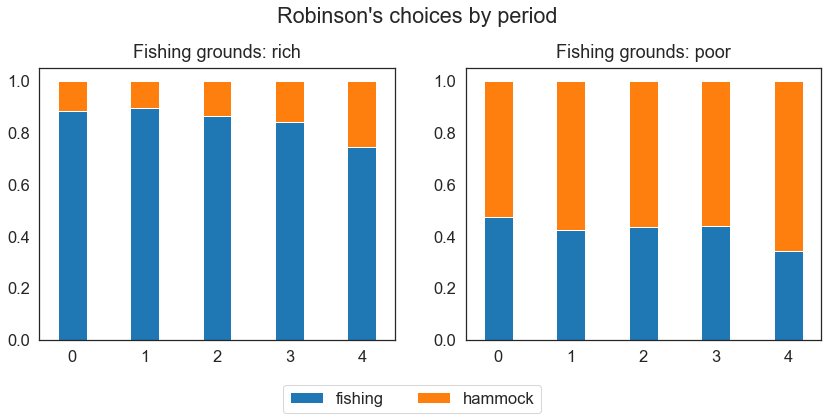

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for i, observable in enumerate(["rich", "poor"]):
    df.query("Fishing_Grounds == @observable").groupby("Period").Choice.value_counts(
        normalize=True,
    ).unstack().plot.bar(width=0.4, stacked=True, rot=0, legend=False, ax=ax[i])
    ax[i].set_title("Fishing grounds: " + observable, pad=10)
    ax[i].xaxis.label.set_visible(False)

plt.legend(loc="lower center", bbox_to_anchor=(-0.15, -0.3), ncol=2)
plt.suptitle("Robinson's choices by period", y=1.05)

plt.show()

## Multiple observables

On top of `"Fishing_Grounds` we add now a second observable, `"Weather"`, which also has two evenly distributed levels: `"sunny"` or `"rainy"`. Experiencing a rainy weather affects, this time negatively, the **non-pecuniary reward** for relaxing on the hammock: 

$$\begin{align}
N^h = \alpha^h + \delta^h \unicode{x1D7D9}_{\{W = "rainy"\}} \\
\end{align}$$

where $\delta^h < 0$. The intuition is simple: Robinson finds it less pleasant to spend time on his hammock when it's raining. 

We again modify `params` and `options` to include this new characteristic:

In [9]:
params.loc[("observable_weather_rainy", "probability"), "value"] = 0.5
params.loc[("observable_weather_sunny", "probability"), "value"] = 0.5
params.loc[("nonpec_hammock", "rainy_weather"), "value"] = -0.15

In [10]:
options["covariates"] = {
    "constant": "1",
    "rich_fishing_grounds": "fishing_grounds == 'rich'",
    "rainy_weather": "weather == 'rainy'",
}

When inspecting a simulated dataset, we can see that the observable `"Weather"` has now its column:

In [11]:
simulate = rp.get_simulate_func(params, options)
df_eq = simulate(params)

In [12]:
df_eq.head()

Experience_Fishing Fishing_Grounds Weather  \
Identifier Period                                               
0          0                        0            rich   rainy   
           1                        1            rich   rainy   
           2                        1            rich   rainy   
           3                        2            rich   rainy   
           4                        3            rich   rainy   

                   Shock_Reward_Fishing  Meas_Error_Wage_Fishing  \
Identifier Period                                                  
0          0                   1.431303                        1   
           1                   0.383519                        1   
           2                   0.950278                        1   
           3                   0.582585                        1   
           4                   1.680125                        1   

                   Shock_Reward_Hammock  Meas_Error_Wage_Hammock   Choice  \
Identifier Period                                                           
0          0                   0.515252                        1  fishing   
           1                   0.529793                        1  hammock   
           2                  -0.189833                        1  fishing   
           3                  -0.585088                        1  fishing   
           4                  -0.108781                        1  fishing   

                       Wage  Discount_Rate  ...  Nonpecuniary_Reward_Fishing  \
Identifier Period                           ...                                
0          0       1.431303           0.95  ...                          0.1   
           1            NaN           0.95  ...                          0.1   
           2       1.282740           0.95  ...                          0.1   
           3       1.061539           0.95  ...                          0.1   
           4       4.132441           0.95  ...                          0.1   

                   Wage_Fishing  Flow_Utility_Fishing  Value_Function_Fishing  \
Identifier Period                                                               
0          0           1.431303              1.531303               10.743857   
           1           0.517697              0.617697                8.690305   
           2           1.282740              1.382740                6.273141   
           3           1.061539              1.161539                4.055768   
           4           4.132441              4.232441                4.232441   

                   Continuation_Value_Fishing  Nonpecuniary_Reward_Hammock  \
Identifier Period                                                            
0          0                         9.697426                         1.85   
           1                         8.497482                         1.85   
           2                         5.147790                         1.85   
           3                         3.046558                         1.85   
           4                         0.000000                         1.85   

                   Wage_Hammock  Flow_Utility_Hammock  Value_Function_Hammock  \
Identifier Period                                                               
0          0                NaN              2.365252                9.709010   
           1                NaN              2.379793                8.697721   
           2                NaN              1.660167                5.720724   
           3                NaN              1.264912                3.604786   
           4                NaN              1.741219                1.741219   

                   Continuation_Value_Hammock  
Identifier Period                              
0          0                         7.730271  
           1                         6.650451  
           2                         4.274271  
           3                         2.463026  
           4  

Note that `Weather` and `Fishing_Grounds` are independent, as we did not specify any additional constraint on their probability distribution. 

We can decrease Robinson's probability of experiencing rainy weather to show how the observables' distribution changes. 

In [13]:
params.loc[("observable_weather_rainy", "probability"), "value"] = 0.2
params.loc[("observable_weather_sunny", "probability"), "value"] = 0.8

In [14]:
simulate = rp.get_simulate_func(params, options)
df_diff = simulate(params)

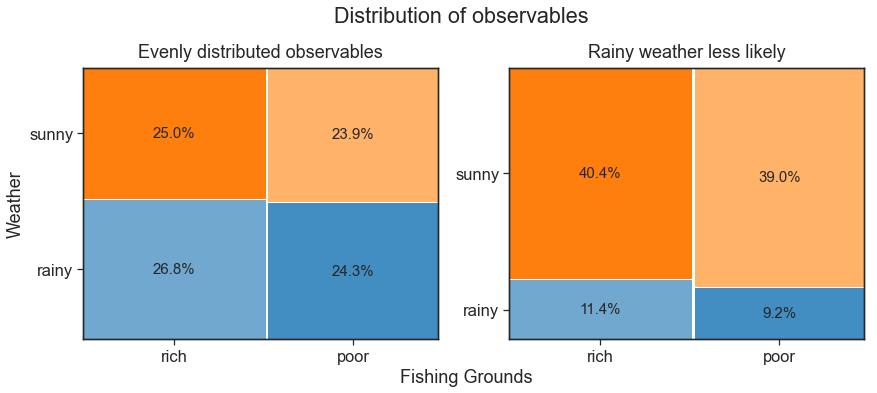

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

colors = ["#ffb369", "#428dc1", "#ff7f0e", "#70a8d0"]
observables = [
    ("poor", "sunny"),
    ("poor", "rainy"),
    ("rich", "sunny"),
    ("rich", "rainy"),
]
titles = ["Evenly distributed observables", "Rainy weather less likely"]

for i, df in enumerate([df_eq, df_diff]):

    crosstab = pd.crosstab(df["Fishing_Grounds"], df["Weather"], normalize="all")

    properties_dict = {}
    for observable, color in zip(observables, colors):
        properties = {observable: [color, "{:.1%}".format(crosstab.loc[observable])]}
        properties_dict.update(properties)

    mosaic(
        df,
        ["Fishing_Grounds", "Weather"],
        ax=ax[i],
        properties=lambda key: {"color": properties_dict[key][0],},
        labelizer=lambda key: properties_dict[key][1],
        gap=0.01,
    )

    ax[i].set_title(titles[i], pad=10)

ax[0].set_xlabel("Fishing Grounds", x=1.08)
ax[0].set_ylabel("Weather")

plt.suptitle("Distribution of observables", y=1.05)
plt.show()

Moreover, we can investigate how the within-sample behavior of Robinson changes according to the fishing grounds and weather conditions that he experiences:

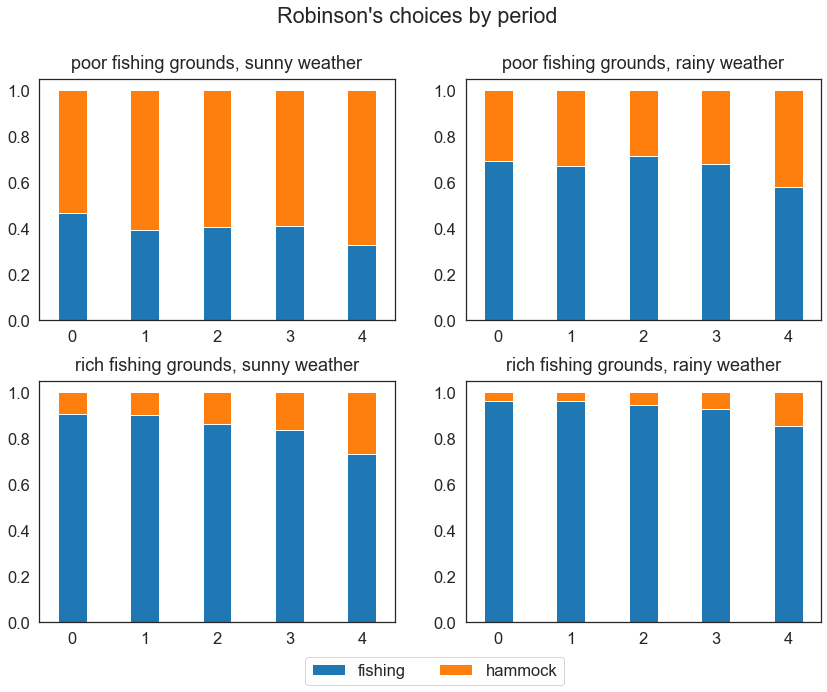

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax = ax.flatten()

plt.subplots_adjust(hspace=0.25)

for i, observable in enumerate(observables):
    (
        df_eq.query("Fishing_Grounds == @observable[0] and Weather == @observable[1]")
        .groupby("Period")
        .Choice.value_counts(normalize=True)
        .unstack()
        .plot.bar(width=0.4, stacked=True, rot=0, ax=ax[i], legend=False)
    )
    ax[i].xaxis.label.set_visible(False)
    ax[i].set_title(
        observable[0] + " fishing grounds, " + observable[1] + " weather", pad=10
    )

plt.legend(loc="right", bbox_to_anchor=(0.3, -0.2), ncol=2)
plt.suptitle("Robinson's choices by period")

plt.show()

The figure shows that different realizations of observables lead to different incentives for Robinson: His engagement in fishing decreases with poor fishing grounds or a sunny weather, while it increases with rich fishing grounds and rain. 